# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Loading the banana dataset from OpenML

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10, length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = sign.(y .- 0.5)

50-element Vector{Float64}:
 -1.0
  1.0
 -1.0
 -1.0
  1.0
 -1.0
 -1.0
 -1.0
 -1.0
  1.0
  ⋮
 -1.0
 -1.0
 -1.0
  1.0
  1.0
 -1.0
  1.0
  1.0
  1.0

### We create a function to visualize the data

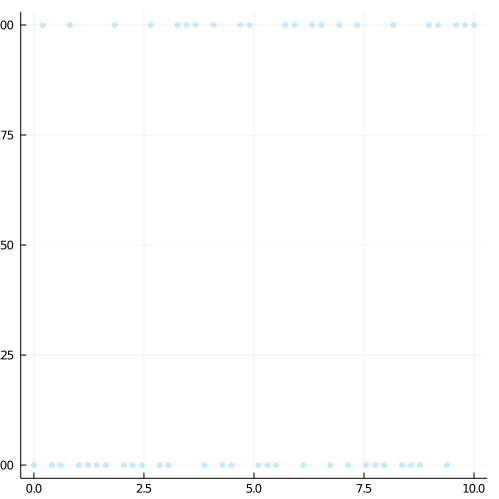

In [3]:
function plot_data(x, y; size=(300,500))
    Plots.scatter(x,
                y,
                alpha=0.2,
                markerstrokewidth=0.0,
                lab="",
                size=size
            )
end
plot_data(x, y; size = (500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign,
            kernel,
            LogisticLikelihood(),
            AnalyticVI(),
            optimiser = false
            )
@time train!(mfull, 5)

[ Info: Running full model
  0.774265 seconds (1.14 M allocations: 66.504 MiB, 99.30% compilation time)


### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y,
            kernel,
            LogisticLikelihood(),
            GibbsSampling(),
            optimiser = false
            )
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:06:27
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:03:16
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:02:10
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:37
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:18
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:01:04
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:55
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:48
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:43
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:38
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:35
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:32
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.41327430052437286, 0.6361659190398015, 0.7344100074513173, 0.6723874985398385, 0.43064676753510556, 0.013397512370892595, -0.4449099014559148, -0.8934296410301873, -1.2122160920529708, -1.3405412364516194  …  -0.14057583833622145, -0.11446730744394545, -0.09141099441876296, -0.14466047301222854, -0.19088422654729692, -0.31002070834267265, -0.4081025640262831, -0.44829279941364586, -0.4207747692381736, -0.2599946842168406]]
 [[0.7414064022458493, 0.5168764478890955, 0.15702367877788836, -0.3217874309864227, -0.853978511101957, -1.3780651790851959, -1.8390456494976295, -2.1830756210741673, -2.3569317630047206, -2.3382515314815375  …  -0.10816055957673615, 0.21052017337737783, 0.5539213968147803, 0.945758375277303, 1.3312189837218857, 1.6959438120527945, 1.978255656825151, 2.1564923719291413, 2.2192377264008876, 2.223496497591052]]
 [[0.3557282557283084, 0.14713410517456782, -0.05681743477326168, -0.2722352382692429, -0.493115860212321, -

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

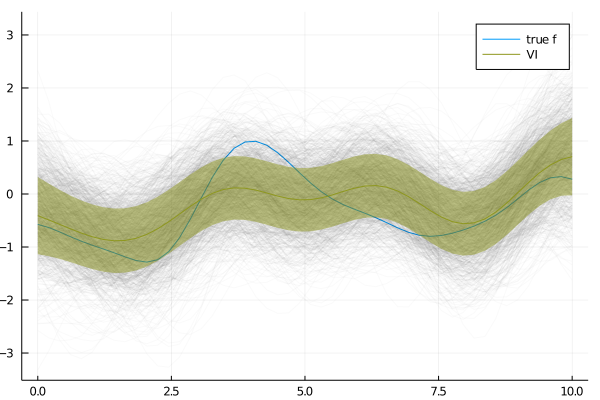

In [6]:
p1 = plot(x, f, label="true f")
plot!(x, samples, label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]), ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

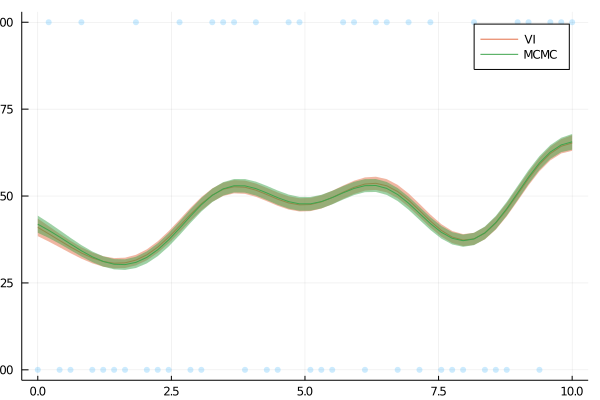

In [7]:
p2 = plot_data(x, y; size=(600,400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*